In [12]:
import cv2, numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Load Parameters

In [13]:
from utils import read_json

params = read_json('parameters.json')

RESIZE_X = params['resize']['x']
RESIZE_Y = params['resize']['y']
ITEM_FOLDER = params['item_folder']

## Input Data
* Image of the bin
* Mask of recognised items
* List of recognised items

In [14]:
bin_stamp = '170405145336'
contents = ["Colgate_Toothbrush_4PK","Epsom_Salts","Duct_Tape",
            "Bath_Sponge","Crayons","Burts_Bees_Baby_Wipes"]

In [4]:
bin_stamp = '170405145538'
contents = ["glue_sticks","tissue_box","laugh_out_loud_jokes",
            "toilet_brush","expo_eraser","table_cloth"]

In [15]:
contents = [s.lower() for s in contents]

['duct_tape', 'bath_sponge', 'burts_bees_baby_wipes']

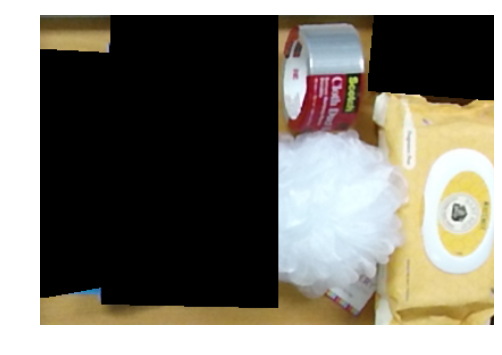

In [16]:
from utils_io import imread_rgb, imread_gray, read_json

image_bin = imread_rgb('bin/' + bin_stamp + '.png')
image_mask = imread_gray('bin/' + bin_stamp + '_item_mask.pgm')
image_bin = cv2.bitwise_and(image_bin, image_bin, mask=image_mask)
plt.imshow(image_bin); plt.axis('off');
data = read_json('bin/' + bin_stamp + '_items.json')
recognised_items = [name for name, proj in data]
items = [item for item in contents if not item in recognised_items]
items

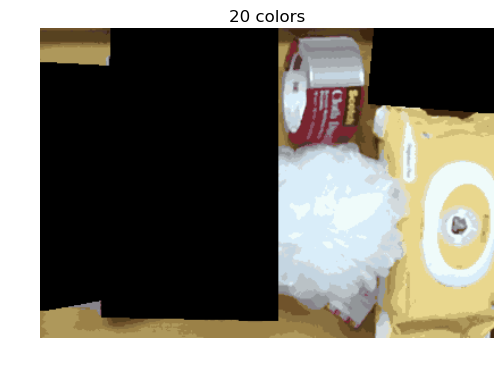

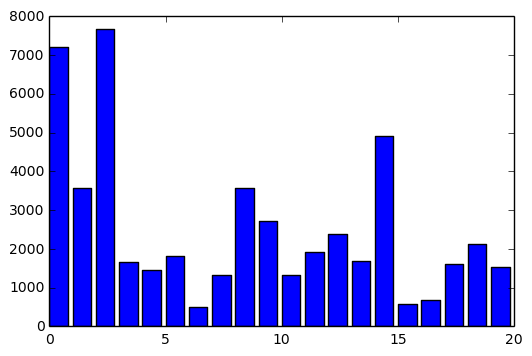

In [17]:
from utils_color import cluster_colors

positions, weights = cluster_colors(image_bin, image_mask, items, n_cc=20)

In [18]:
weights

[[(0.21737132054504038, 'burts_bees_baby_wipes')],
 [(0.16892080602886464, 'bath_sponge'),
  (0.10064042696519586, 'burts_bees_baby_wipes')],
 [],
 [(0.34096318218506177, 'duct_tape'),
  (0.7565547364229781, 'bath_sponge'),
  (0.46790119562131299, 'burts_bees_baby_wipes')],
 [],
 [(0.1955855874500714, 'duct_tape')],
 []]

In [19]:
pos_ok = [(p,w[0][1]) for p,w in zip(positions, weights) if len(w)==1]
pos_unkw = [(p,w) for p,w in zip(positions, weights) if len(w)>1]

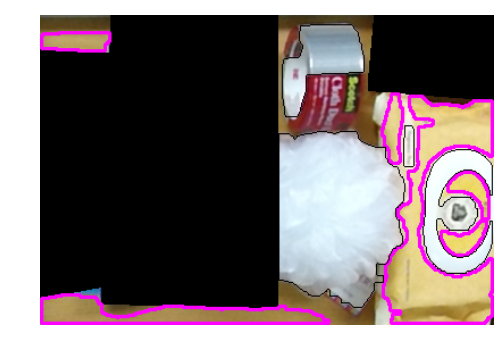

In [20]:
it_col = {'table_cloth':(255,0,255),'tissue_box':(0,255,255),'glue_sticks':(255,0,0),'toilet_brush':(255,255,0),
          'burts_bees_baby_wipes':(255,0,255),'bath_sponge':(0,255,255),'duct_tape':(255,0,0)}
image_disp = image_bin.copy()
#mask_disp  = 255 - image_mask
contours = {}
for item in items:
    contours[item] = []
    it_pos = [p for p,it in pos_ok if it==item]
    for cnt in it_pos:
        contours[item] += cnt
        cv2.drawContours(image_disp,cnt,-1,it_col[item],2)
        #cv2.drawContours(mask_disp,cnt,-1,(255,),-1)
for pos,w in pos_unkw:
    for cnt in pos:
        cv2.drawContours(image_disp,cnt,-1,(0,0,0),1)
        #cv2.drawContours(mask_disp,cnt,-1,(255,),-1)
plt.imshow(image_disp); plt.axis('off');

Choose biggest area contour
for each contour in item
    if bbox of added contour not overlaps other item (including mask) add contour
    

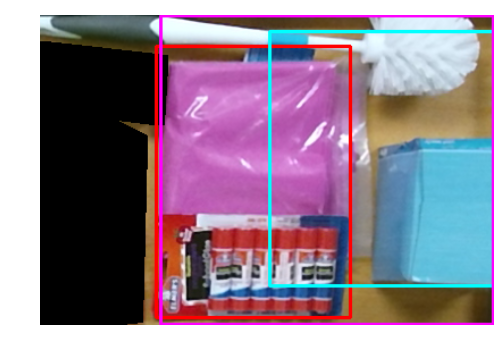

In [11]:
image_disp = image_bin.copy()
for item in items:
    if contours[item]:
        x,y,w,h = cv2.boundingRect(np.vstack(tuple(contours[item])))
        cv2.rectangle(image_disp, (x,y), (x+w,y+h), it_col[item],2)
plt.imshow(image_disp); plt.axis('off');

### Compute EMD of boxes?